# Vehicle Recall Data - David's Work with CMPL and Mileage
### Initial Questions
* What Make/Model is being recalled?
    * See Fig 1, Fig 2, and Fig 3
    * Honda, Ford, Blue Bird most common
* What specific problems led to the recall?
    * Most common by far is airbags (Fig 5)
* Is this correlated to an increase in defects or better QA?
* At what mileage did we start seeing the problem?
    * Average Miles at Failure: 68334.08213141191
* Did an increase in complaints lead to a recall?
    * Generally, as the number of recalls go up, the number of complaints also go up (Fig 4)

# Required Code

This is the code required to load the datasets we need

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import re

data_path = 'data'
fields_path = 'fields'

# Read and parse a file containing column names for a dataset.
# Returns a list of strings (the column names).
def load_column_names(columns_file_name):
    file = open(columns_file_name)
    column_names = []
    readingFields = False
    for line in file:
        if readingFields:
            if re.match('^[0-9]', line):
                split_line = line.split()
                column_names.append(split_line[1])
        elif line.startswith('Field#'):
            readingFields = True
    file.close()
    return column_names
#}

# Load a dataest by its abbreviated names (ex: RCL).
def load_data_file(name, encoding):
    
    # Read the column names from a separate file.
    fields_file_name = fields_path + '/' + name + '.txt';
    names = load_column_names(fields_file_name)
    
    # Read the data from a CSV file.
    data_file_name = 'FLAT_' + name + '.txt';
    df = pd.read_csv(data_path + '/' + data_file_name,
                     delimiter='\t', header=None, encoding=encoding, names=names)
    
    return df
#}

print("done")

done


# Data Exploration

In [1]:
# Load complaints dataset.
cmpl_df = load_data_file('CMPL', encoding='iso-8859-1');

# Load recalls dataset.
rcl_df = load_data_file('RCL', encoding='latin1');

NameError: name 'load_data_file' is not defined

In [ ]:

#plt.figure()
#cmpl_df['MILES'].plot(kind='box')
#plt.gcf()
#cmpl_df['MILES'].describe()

col_miles = cmpl_df['MILES'].dropna();


#cmpl_df[(cmpl_df['MILES'] >= 99) & (cmpl_df['MILES'] <= 101)]["MILES"]
#cmpl_df[(cmpl_df['MILES'] < 0)]["MILES"]

clean_miles = cmpl_df[(cmpl_df["MILES"] >= 0) & (cmpl_df["MILES"] < 300000)]["MILES"]

clean_miles = clean_miles / 1000;

clean_df = cmpl_df[(cmpl_df["MILES"] >= 0) & (cmpl_df["MILES"] < 300000)]

#clean_miles = cmpl_df['VEH_SPEED'].dropna();
#clean_miles = pd.to_numeric(cmpl_df['NUM_CYLS'], errors='coerce').dropna()
#clean_miles = clean_miles[(clean_miles >= 2) & (clean_miles <= 10)]
#clean_miles = cmpl_df[(cmpl_df['VEH_SPEED'] >= 140) & (cmpl_df['VEH_SPEED'] < 1000)]['VEH_SPEED']

clean_miles = cmpl_df['DEATHS']
clean_miles = clean_miles[(clean_miles > 10) & (clean_miles <= 99)]


plt.figure()
clean_miles.hist(bins=20, color='#FF5500')
#clean_df.plot(kind='scatter', x='MILES', y='OCCURENCES');
plt.title("Fig 7 - Milage at Failure", y=1.1)
plt.ylabel('Number of Failures', fontsize=12)
plt.xlabel('Miles at Failure (thousands)', fontsize=12)
plt.gcf()



In [ ]:

clean_df = cmpl_df[(cmpl_df["MILES"] >= 0) & (cmpl_df["MILES"] < 300000)]

plt.figure()
clean_df.plot(kind='scatter', x='MILES', y='OCCURENCES');
plt.title("Fig 5 - Number of Failures per Mile at Failure")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Miles at Failure', fontsize=12)
plt.gcf()

#create_box_graph(clean_df, col_x='MILES', col_y='OCCURENCES', num_bins=10);



In [ ]:
import math;
matplotlib.style.use('ggplot')

curr_df = cmpl_df[["MILES", "OCCURENCES"]].dropna();
#curr_df = [(curr_df["MILES"] >= 980000) & (curr_df["MILES"] < 1000000)]

numBins = 20 + 1;
bins = py.linspace(0, 200000, numBins);
#bins = py.linspace(0, 50000, numBins);
#bin_df = pd.cut(curr_df['MILES'], bins, labels=bins[1:])

#print(bin_df)

binLabels = bins[1:];
binLabels = list(map(lambda x: math.floor(x / 1000), binLabels));
    
    
plt.figure()
curr_df.groupby(pd.cut(curr_df["MILES"], bins, labels=binLabels))["OCCURENCES"].sum().plot(kind='bar', color='#FF2200')
#bin_df.value_counts(sort=False).plot(kind='bar')
plt.title("Fig 8 - Number of Failure Occurrences by Mile", y=1.1);
plt.xlabel("Miles at Failure (thousands)", fontsize=12);
plt.ylabel("Number of Occurrences", fontsize=12);
plt.gcf()

#bins = py.linspace(0, 300000, numBins)
#bins = math.floor(bins)
#bins
#bin_df.value_counts(sort=False)

#cmpl_df['MILES'].value_counts()
#bin_df.describe()
#cmpl_df["MILES"].describe()

#bins = [900000, 1000000];
#cmpl_df.groupby(pd.cut(cmpl_df['MILES'], bins))["OCCURENCES"].describe()

#curr_df["OCCURENCES"].describe()
#curr_df[(curr_df["OCCURRENCES"] >= 980000) & (curr_df["MILES"] < 1000000)]

In [ ]:
cmpl_df = cmpl_df_new[cmpl_df_new["CMPLID"] > 1347687];

matplotlib.style.use('ggplot')

orange = '#FF6600';
blue = '#6666FF';

plotParams = {'labels':['No','Yes'], 'colors':[blue, orange], 'autopct':'%1.1f%%'}
titleOffset = 1.1;

plt.figure()
#cmpl_df["CRASH"].value_counts().plot.pie(labels=['No','Yes'], colors=[blue, orange], autopct='%1.1f%%');
cmpl_df["CRASH"].value_counts().plot.pie(**plotParams);
plt.title("Defects involving a Crash", y=titleOffset);
plt.axis('equal')
plt.ylabel("");
plt.show();

plt.figure()
((cmpl_df["INJURED"] > 0) | (cmpl_df["DEATHS"] > 0)).value_counts().plot.pie(**plotParams);
plt.title("Defects Involving Injuries or Death", y=titleOffset);
plt.axis('equal')
plt.ylabel("");
plt.show();

crashes_df = cmpl_df[cmpl_df["CRASH"] == 'Y'];

plt.figure()
#((cmpl_df["INJURED"] > 0) | (cmpl_df["DEATHS"] > 0)).value_counts().plot.pie();
((crashes_df["INJURED"] > 0) | (crashes_df["DEATHS"] > 0)).value_counts().plot.pie(**plotParams);
plt.title("Crashes Involving Injuries or Death", y=titleOffset);
plt.axis('equal')
plt.ylabel("");
plt.show();



In [ ]:
cmpl_df = load_data_file('CMPL', encoding='iso-8859-1')
#cmpl_df_new = load_data_file('CMPL_NEW', encoding='iso-8859-1')

print(cmpl_df["CMPLID"].max())
print(cmpl_df_new["CMPLID"].max())
print(cmpl_df_new["CMPLID"].max() - cmpl_df["CMPLID"].max())

cmpl_df_new[cmpl_df_new["CMPLID"] > 1347687]["CMPLID"].describe()

#cmpl_df['OCCURENCES'].describe()

#clean_col = cmpl_df[(cmpl_df["OCCURENCES"] >= -1000) & (cmpl_df["OCCURENCES"] < 20)]["OCCURENCES"]

#plt.figure()
#clean_col.hist(bins=20, color='#FF5500')
#clean_df.plot(kind='scatter', x='MILES', y='OCCURENCES');
#plt.title("Fig 7 - Milage at Failure", y=1.1)
#plt.ylabel('Number of Failures', fontsize=12)
#plt.xlabel('Miles at Failure (thousands)', fontsize=12)
#plt.gcf()

# Data cleaning for prediction

### Load the Complaints dataset

In [3]:
# Load the complaints dataset.
cmpl_train_df = load_data_file('CMPL', encoding='iso-8859-1').head(10000);

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (15,22,26,32,33,34,35,36,38,39,40,41,42,43,44,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Filter and clean the Complaints dataset

In [4]:
# Create list of the columns we will use.
key_cols = ['MAKETXT', 'MODELTXT', 'YEARTXT','COMPDESC']
cat_cols = ['DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE']
bool_cols = ['CRASH', 'FIRE', 'POLICE_RPT_YN', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']
numer_cols = bool_cols + ['INJURED', 'DEATHS', 'MILES', 'OCCURENCES', 'NUM_CYLS', 'VEH_SPEED']
all_cols = key_cols + numer_cols + cat_cols

# Filter out rows with invalid make, model, or year.
# Also filter out any non-vehicles.
clean_train_df = cmpl_train_df[(cmpl_train_df['MAKETXT'] != 'UNKNOWN') &
                   (cmpl_train_df['MODELTXT'] != 'UNKNOWN') &
                   (cmpl_train_df['YEARTXT'] > 1900) &
                   (cmpl_train_df['YEARTXT'] < 2020) &
                   (cmpl_train_df['PROD_TYPE'] == 'V')][all_cols + ['CMPLID']].copy()

# shoulda bought more ram
del cmpl_train_df

# Convert certain columns to a numerical data type.
clean_train_df['NUM_CYLS'] = pd.to_numeric(clean_train_df['NUM_CYLS'], errors='coerce')

# Replace particular "bogus" values with NaN, which get filled later.
clean_train_df['INJURED'] = clean_train_df['INJURED'].replace(99, np.nan).fillna(0)
clean_train_df['DEATHS'] = clean_train_df['DEATHS'].replace(99, np.nan).fillna(0)

# Clamp the values for specific numerical columns.
clean_train_df['NUM_CYLS'] = clean_train_df['NUM_CYLS'].clip(4, 8)
clean_train_df['MILES'] = clean_train_df['MILES'].clip(0, 300000)
clean_train_df['OCCURENCES'] = clean_train_df['OCCURENCES'].clip(1, 10)
clean_train_df['VEH_SPEED'] = clean_train_df['VEH_SPEED'].clip(0, 100)

#Clean values in component descriptions
#Custom split function to pass to apply
def split(comp):
    if type(comp) != str:
        return ''
    return comp.split(':')[0]

#Generalize the names of each component
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].apply(split)

# Fix differences between component names in complaints and recalls
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].replace('FUEL/PROPULSION SYSTEM','FUEL SYSTEM').replace('AIR BAG','AIR BAGS')
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].replace('OTHER','').replace('UNKNOWN OR OTHER','')

# Replace 'Y' and 'N' with 1 and 0 for boolean columns.
# Also convert them to numeric so we can average them.
# This will allow us to get a percentage of 'yes' for each vehicle type.
for column in bool_cols:
    clean_train_df[column] = clean_train_df[column].replace('Y', 1).replace('N', 0)
    clean_train_df[column] = pd.to_numeric(clean_train_df[column])

# Set aside a portion of the train dataset to be the test dataset.
split_id = clean_train_df['CMPLID'].max() - 10000
clean_test_df = clean_train_df[clean_train_df['CMPLID'] > split_id].copy()
clean_train_df = clean_train_df.drop('CMPLID', axis=1)
clean_test_df = clean_test_df.drop('CMPLID', axis=1)

# Print out the resulting clean data set
clean_train_df[all_cols].head(10)

,MAKETXT,MODELTXT,YEARTXT,COMPDESC,CRASH,FIRE,POLICE_RPT_YN,ORIG_OWNER_YN,ANTI_BRAKES_YN,CRUISE_CONT_YN,...,INJURED,DEATHS,MILES,OCCURENCES,NUM_CYLS,VEH_SPEED,DRIVE_TRAIN,FUEL_SYS,FUEL_TYPE,TRANS_TYPE
0,MERCURY,COUGAR,1995.0,"SERVICE BRAKES, HYDRAULIC",NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,GMC,SONOMA,1995.0,"SERVICE BRAKES, HYDRAULIC",NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NISSAN,MAXIMA,1987.0,VISIBILITY,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,FORD,RANGER,1994.0,ENGINE AND ENGINE COOLING,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GMC,SONOMA,1995.0,ELECTRICAL SYSTEM,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MAZDA,626,1991.0,SEAT BELTS,1.0,0.0,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
6,LINCOLN,TOWN CAR,1994.0,"SERVICE BRAKES, HYDRAULIC",1.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7,GMC,SONOMA,1995.0,STEERING,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,FORD,PROBE,1991.0,SEAT BELTS,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
10,FORD,WINDSTAR,1995.0,"SERVICE BRAKES, HYDRAULIC",NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

clean_train_df

### Group complaints by make/model/year and perform aggregate functions on the column values

Warning: this step takes a few minutes to perform all the aggregate functions

In [5]:
# Aggregate function which Returns the mode of a series.
# If there is no valid mode, but there are any amount of
# non-null values, then the first non-null value is returned.
# Otherwise, if all values are NaN, then NaN is returned
def aggMode(x):
    column_mode = x.mode()
    
    # If there is a valid mode, return it
    if column_mode.count() > 0:
        return column_mode[0]
   
    # if there are any non-null values, return one of them
    first_valid = x.first_valid_index()
    if first_valid != None:
        return x[first_valid]
    
    return np.nan
#}

In [6]:
# Group the dataset by the key columns (make/model/year/component)
#grouped = clean_train_df.head(3000).groupby(key_cols)
grouped = clean_train_df.groupby(key_cols)

# Perform aggregate functions on the columns for each vehicle type.
# Aggregate with the mode for categorical columns
# Aggregate with the mean for numerical columns
grouped_df = pd.DataFrame()
for col in cat_cols:
    grouped_df[col] = grouped[col].agg(aggMode)
for col in numer_cols:
    grouped_df[col] = grouped[col].mean()

# Add in a column for the number of complaints for each vehicle-component.
grouped_df['COMPLAINTS'] = grouped.size()
numer_cols.append('COMPLAINTS');
all_cols.append('COMPLAINTS');

print('done')

done


### Replace missing values with the mean or mode for that column over the entire dataset

In [7]:
# Replace NaN with mode for categorical columns
for col in cat_cols:
    grouped_df[col] = grouped_df[col].fillna(grouped_df[col].mode()[0])

# Replace NaN with mean for numerical columns
for col in numer_cols:
    grouped_df[col] = grouped_df[col].fillna(grouped_df[col].mean())

print('done')

done


In [8]:
# Print out the grouped dataset.
grouped_df

DRIVE_TRAIN  \
MAKETXT      MODELTXT     YEARTXT COMPDESC                                
ACURA        INTEGRA      1987.0  SEATS                             FWD   
                          1989.0  SEAT BELTS                        FWD   
                                  SERVICE BRAKES, HYDRAULIC         FWD   
                          1990.0  SEAT BELTS                        FWD   
                          1991.0  SERVICE BRAKES, HYDRAULIC         FWD   
                          1994.0  ENGINE AND ENGINE COOLING         FWD   
                                  EQUIPMENT                         FWD   
                                  EXTERIOR LIGHTING                 FWD   
                                  LATCHES/LOCKS/LINKAGES            FWD   
                                  SEATS                             FWD   
                                  SERVICE BRAKES, HYDRAULIC         FWD   
                                  STRUCTURE                         FWD   
                                  TIRES                             FWD   
                                  VEHICLE SPEED CONTROL             FWD   
                                  VISIBILITY                        FWD   
             LEGEND       1986.0  FUEL SYSTEM, GASOLINE             FWD   
                                  VEHICLE SPEED CONTROL             FWD   
                          1988.0  EQUIPMENT                         FWD   
                                  SERVICE BRAKES, HYDRAULIC         FWD   
                                  VEHICLE SPEED CONTROL             FWD   
                          1989.0  ELECTRICAL SYSTEM                 FWD   
                          1990.0  SEAT BELTS                        FWD   
                          1991.0  AIR BAGS                          FWD   
                                  SERVICE BRAKES, HYDRAULIC         FWD   
                          1992.0  AIR BAGS                          FWD   
                          1993.0  CHILD SEAT                        FWD   
                                  COMMUNICATIONS                    FWD   
                                  SEAT BELTS                        FWD   
                                  SERVICE BRAKES, HYDRAULIC         FWD   
                          1994.0  ELECTRICAL SYSTEM                 FWD   
...                                                                 ...   
VOLVO        850          1994.0  SERVICE BRAKES, HYDRAULIC         FWD   
                                  VEHICLE SPEED CONTROL             FWD   
                                  VISIBILITY                        FWD   
                          1995.0  TIRES                             FWD   
                                  WHEELS                            FWD   
             940          1992.0  ELECTRICAL SYSTEM                 FWD   
                          1993.0  AIR BAGS                          FWD   
                                  POWER TRAIN                       FWD   
                                  SERVICE BRAKES, HYDRAULIC         FWD   
                          1994.0  ENGINE AND ENGINE COOLING         FWD   
                                  STRUCTURE                         FWD   
                                  VEHICLE SPEED CONTROL             FWD   
             960          1994.0  ENGINE AND ENGINE COOLING         FWD   
WESTERN STAR CONVENTIONAL 1986.0  SUSPENSION                        FWD   
WHITE TRUCK  WHITE TRUCK  1989.0  ELECTRICAL SYSTEM                 FWD   
WINNEBAGO    CHIEFTAN     1992.0  SERVICE BRAKES, HYDRAULIC         FWD   
                                  STEERING                          FWD   
             ELANDAN      1985.0  FUEL SYSTEM, GASOLINE             FWD   
                          1986.0  ELECTRICAL SYSTEM                 FWD   
                                  ENGINE AND ENGINE COOLING         FWD   
             SUN CRUISER  1995.0  VEHICLE SPEED CONTROL             FWD   
          

### Check which vehicle types exist in the Recalls dataset

In [9]:
# Load the recall dataset
rcl_df = load_data_file('RCL', encoding='latin1');

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [10]:
# Rename the component field in recalls so it matches complaints
recalled_set = rcl_df.rename(columns = {'COMPNAME':'COMPDESC'})

# Create the set of vehicle types from the recalled dataset.
# Filter out rows with invalid make, model, or year.
# Also filter out any non-vehicles.
recalled_set = recalled_set[(rcl_df['MAKETXT'] != 'UNKNOWN') &
                      (rcl_df['MODELTXT'] != 'UNKNOWN') &
                      (rcl_df['YEARTXT'] > 1900) &
                      (rcl_df['YEARTXT'] < 2020) &
                      (rcl_df['RCLTYPECD'] == 'V')][key_cols].copy()

# Generalize the names of each component
recalled_set['COMPDESC'] = recalled_set['COMPDESC'].apply(split)

# Make the recalled set only have unique vehicle types,
# mostly for efficiency in the next step.
recalled_set = recalled_set[key_cols].groupby(key_cols).size()


In [11]:
# Create the column in the complaints set which says
# whether a vehicle type is in the recalled set.
grouped_df['RECALLED'] = False
for index, row in grouped_df.iterrows():
    row['RECALLED'] = index in recalled_set.index
    grouped_df.loc[index] = row
    
print('done')

MAKETXT       MODELTXT      YEARTXT  COMPDESC                 
ACURA         INTEGRA       1987.0   SEATS                        False
                            1989.0   SEAT BELTS                    True
                                     SERVICE BRAKES, HYDRAULIC    False
                            1990.0   SEAT BELTS                    True
                            1991.0   SERVICE BRAKES, HYDRAULIC    False
                            1994.0   ENGINE AND ENGINE COOLING    False
                                     EQUIPMENT                    False
                                     EXTERIOR LIGHTING            False
                                     LATCHES/LOCKS/LINKAGES       False
                                     SEATS                        False
                                     SERVICE BRAKES, HYDRAULIC    False
                                     STRUCTURE                    False
                                     TIRES                        False
 

# Random Decision Forest Prediction

## Import required libraries

In [103]:
# Import required libraries
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## Prepare data for training and validation

In [104]:
# Copy the dataset for prediction.
fullData = grouped_df.copy();

In [128]:
# Drop columns that have missing values. Our previous
# steps would have filled all missing values UNLESS
# the column is entirely filled with null. Therefore,
# just drop columns that are null, they don't tell us anything.
for col in cat_cols + numer_cols:
    if fullData[col].isnull().any():
        print('Dropping column ', col)
        fullData[col].drop(col, axis=1)

# Create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    fullData[var] = number.fit_transform(fullData[var].astype('str'))

# Target variable is also a categorical so convert it
fullData['RECALLED'] = number.fit_transform(fullData['RECALLED'].astype('str'))

# Split train dataset into train and validation sub-sets
fullData['is_train'] = np.random.uniform(0, 1, len(fullData)) <= .75
Train, Validate = fullData[fullData['is_train']==True], fullData[fullData['is_train']==False]

In [129]:
# Get a list of the defining features.
features = list(set(list(fullData.columns)) - set(['RECALLED']))

x_train = Train[list(features)].values
y_train = Train['RECALLED'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED'].values
#x_test=test[list(features)].values

## Calculate and plot the ROC Curve

In [130]:
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

Area under ROC curve = 0.560623676023


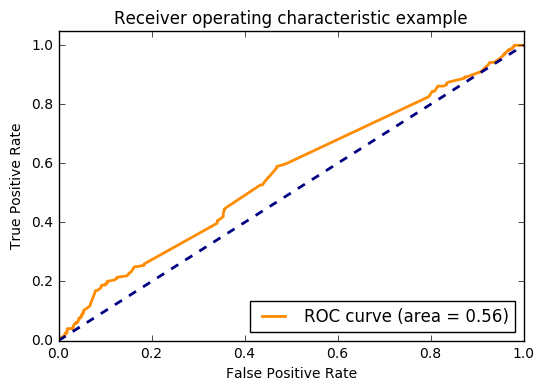

In [131]:
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Calculate the Confusion Matrix

In [139]:
# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

confusion matrix:
[[1058   21]
 [ 215    9]]

1058  non-recalled cars were predicted to be not recalled
21  non-recalled cars were predicted to be recalled
215  recalled cars were predicted to be not recalled
9  recalled cars were predicted to be recalled


## Calculate the Accuracy & Mean Squared Error

In [133]:
print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

accuracy = 0.818879508826
Mean squared error = 0.181120491174
